<a href="https://colab.research.google.com/github/DiegoPincheiraIb/Experiencias_EL5206/blob/master/Lab_Vinos_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Configuraciones preliminares

In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
import random
from random import randint
from pylab import rcParams
from dateutil.relativedelta import relativedelta
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
from tabulate import tabulate
import numpy
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

# Cargar los Datos

In [2]:
df = pd.read_csv("http://www.forecastingbook.com/mooc/AustralianWines.csv?attredirects=0&d=1")
df.head()

,Month,Fortified,Red,Rose,sparkling,Sweet white,Dry white
0,Jan-80,2585,464,112,1686,85,1954
1,Feb-80,3368,675,118,1591,89,2302
2,Mar-80,3210,703,129,2304,109,3054
3,Apr-80,3111,887,99,1712,95,2414
4,May-80,3756,1139,116,1471,91,2226


Se separa el dataframe en tipos de vinos

In [3]:
fortified = df[['Month','Fortified']]
red = df[['Month','Red ']]
rose = df[['Month','Rose ']]
sparkling = df[['Month','sparkling ']]
sweet_white = df[['Month','Sweet white']]
dry_white = df[['Month','Dry white']]

Se verifica si existen datos nulos

In [4]:
print(fortified.isnull().sum(),
      red.isnull().sum(),
      rose.isnull().sum(),
      sparkling.isnull().sum(),
      sweet_white.isnull().sum(),
      dry_white.isnull().sum()
     )

Month        0
Fortified    0
dtype: int64 Month    0
Red      0
dtype: int64 Month    0
Rose     0
dtype: int64 Month         0
sparkling     0
dtype: int64 Month          0
Sweet white    0
dtype: int64 Month        0
Dry white    0
dtype: int64


Si bien no se presentan datos nulos, se destaca la presencia de dos valores marcados como "*" en "rose". Estos se reemplazarán por un valor aleatorio dentro de la desviación estándar de la media más adelante, utilizando la función Reemplazo_Asteriscos() diseñada en el próximo apartado.

# 2.1: Análisis por tipos de vinos

## Funciones para las predicciones

Se modifica un Dataframe objetivo para que tenga los meses en formato "AAAA-MM-DD". A su vez, se imprime el gráfico de comportamiento, y se descompone el modelo en gráficos que permiten observar su tendencia (Trend), comportamiento estacional (Seasonal), y el ruido presente (Residual).

In [5]:
def Reordenamiento_Meses(DF_Obj, Str_Variable,Plot = True):
  DF_Obj = DF_Obj.groupby('Month')[Str_Variable].sum().reset_index()
  DF_Obj['Month'] = pd.to_datetime(DF_Obj['Month'])
  DF_Obj = DF_Obj.set_index('Month')
  Y_DF_Obj = DF_Obj[Str_Variable].resample('MS').mean()
  if Plot:
    Y_DF_Obj.plot(figsize=(18, 8))
    plt.show()
    rcParams['figure.figsize'] = 18, 8
    Decomposition = sm.tsa.seasonal_decompose(Y_DF_Obj, model='additive')
    fig = Decomposition.plot()
    plt.show()
  return Y_DF_Obj

Esta función, dado una serie objetivo, y un booleano opcional, evalua combinaciones de parámetros del método SARIMA, entregando la combinación que da el valor mínimo de AIC, en conjunto con el valor de este. Mediante el booleano opcional es posible imprimir todas las combinaciones si este es igual a True.

In [6]:
def SARIMA_Param(Y_Obj, Show_All = False):
  Min = ''
  Valor_Min = 9999999999999
  p = d = q = range(0, 2)
  pdq = list(itertools.product(p, d, q))
  seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
  for param in pdq:
      for param_seasonal in seasonal_pdq:
          try:
              mod = sm.tsa.statespace.SARIMAX(Y_Obj,
                                              order=param,
                                              seasonal_order=param_seasonal,
                                              enforce_stationarity=False,
                                              enforce_invertibility=False)
              results = mod.fit()
              if Show_All:
                print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
              if results.aic <= Valor_Min:
                Valor_Min = results.aic
                Min = 'ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic)
          except:
              continue
  print('Minimo: ', Min)

Esta función realiza las predicciones.

In [7]:
def Predicciones_12Meses(Y_Obj, Orden_Obj, Seas_Orden_Obj,Diag = True,Plot_Pred = True):
  mod = sm.tsa.statespace.SARIMAX(Y_Obj,
                                order=Orden_Obj,
                                seasonal_order=Seas_Orden_Obj,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
  results = mod.fit()
  if Diag:
    print(results.summary().tables[1])
    results.plot_diagnostics(figsize=(18, 8))
    plt.show()
  pred = results.get_prediction(start = -24,end = len(Y_Obj) + 11, dynamic=False)
  pred_ci = pred.conf_int()
  if Plot_Pred:
    ax = Y_Obj[:].plot(label='Observed')
    pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(18, 8))
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)
    ax.set_xlabel('Date')
    ax.set_ylabel('Fortified Sales')
    plt.legend()
    plt.show()
  y_forecasted = pred.predicted_mean
  y_truth = Y_Obj[-24:]
  print('La media pronosticada de las ventas para los siguientes 12 meses son los siguientes valores:')
  print(y_forecasted[-12:])
  mse = ((y_forecasted - y_truth) ** 2).mean()
  print('El MSE de las predicciones es {}'.format(round(mse, 2)))
  print('El RMSE de las predicciones es {}'.format(round(np.sqrt(mse), 2)))

In [8]:
def Reemplazo_Asteriscos(DF_Obj, Str_Obj):
  DF_Obj_Copia = DF_Obj.copy()
  DF_Obj_Copia[Str_Obj] = DF_Obj_Copia[Str_Obj].replace('\*', np.nan, regex=True)
  Aux = DF_Obj_Copia[Str_Obj][160:180].dropna().astype(int)
  Media = Aux.mean()
  STD = Aux.std()
  Value = Media + (randint(-int(STD),int(STD)))
  DF_Obj_Copia[Str_Obj] = DF_Obj_Copia[Str_Obj].replace(np.nan, Value, regex=True).astype(int)
  return DF_Obj_Copia

## Fortified

In [9]:
y_fortified = Reordenamiento_Meses(fortified, 'Fortified', False)
SARIMA_Param(y_fortified)

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Minimo:  ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:2169.0164995610994


Los resultados anteriores indican que los parámetros más cercanos al modelo consisten en ARIMA(0, 1, 1)x(1, 1, 1, 12)12, con AIC:2169.0164995610994.

In [10]:
Predicciones_12Meses(y_fortified, (0,1,1), (1,1,1,12),Diag = False, Plot_Pred = False)


La media pronosticada de las ventas para los siguientes 12 meses son los siguientes valores:
1995-01-01    1025.272339
1995-02-01    1338.145003
1995-03-01    1812.498338
1995-04-01    2235.931332
1995-05-01    2257.345805
1995-06-01    2458.032145
1995-07-01    2730.501748
1995-08-01    2281.788569
1995-09-01    2102.694126
1995-10-01    1784.691603
1995-11-01    2464.387132
1995-12-01    2425.162183
Freq: MS, dtype: float64
El MSE de las predicciones es 61567.01
El RMSE de las predicciones es 248.13


## Red

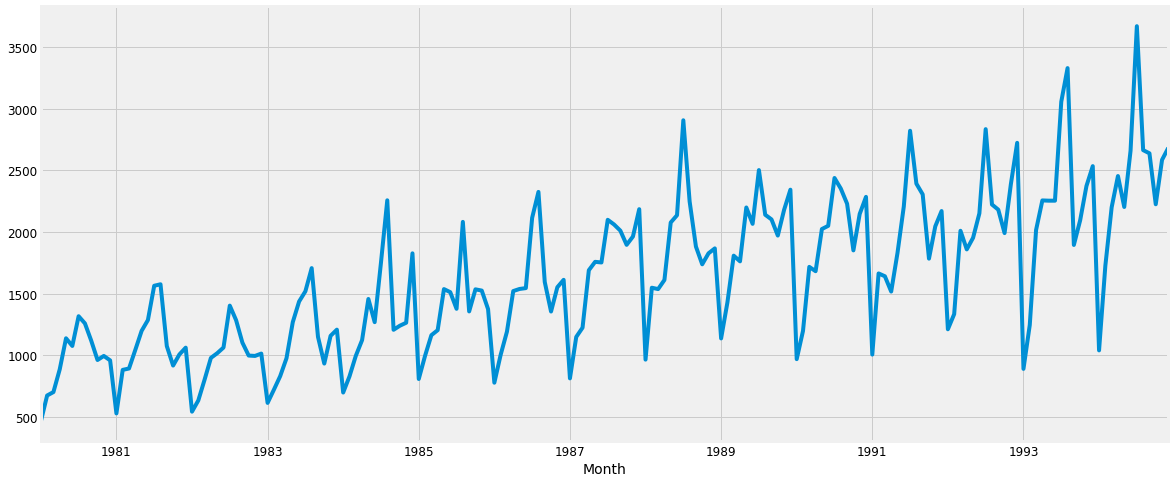

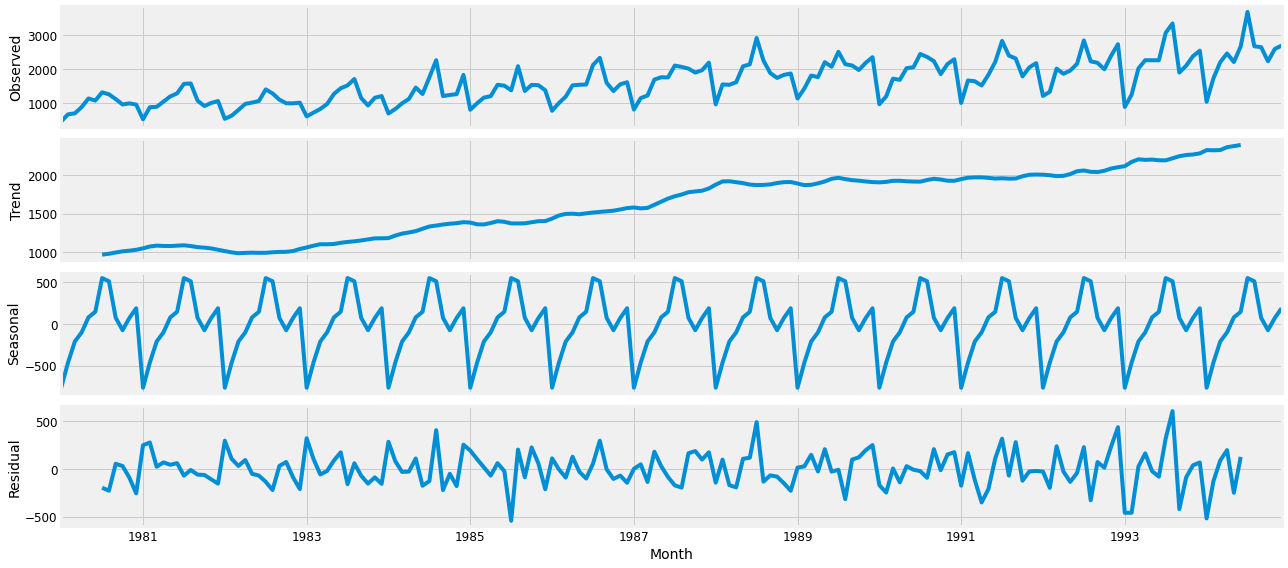

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Minimo:  ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:2086.391382650295


In [11]:
y_red = Reordenamiento_Meses(red, 'Red ')
SARIMA_Param(y_red)

In [12]:
Predicciones_12Meses(y_red, (0,1,1), (0,1,1,12),Diag = False, Plot_Pred = False)


La media pronosticada de las ventas para los siguientes 12 meses son los siguientes valores:
1995-01-01    1366.257040
1995-02-01    1823.064709
1995-03-01    2316.000299
1995-04-01    2437.484569
1995-05-01    2450.595608
1995-06-01    2673.663634
1995-07-01    3448.596986
1995-08-01    2998.255484
1995-09-01    2606.713782
1995-10-01    2392.001663
1995-11-01    2699.084607
1995-12-01    2854.130957
Freq: MS, dtype: float64
El MSE de las predicciones es 95623.4
El RMSE de las predicciones es 309.23


## Rose

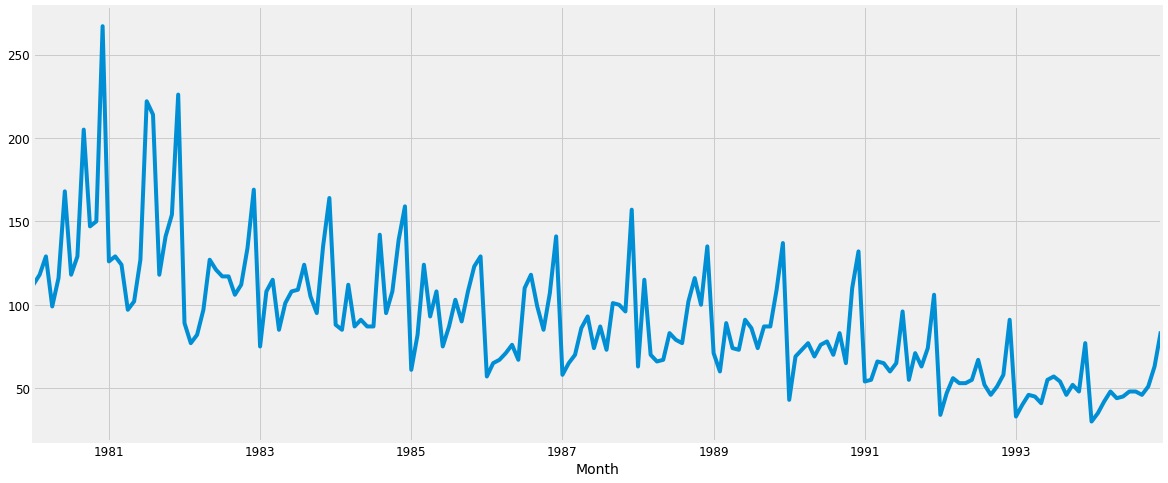

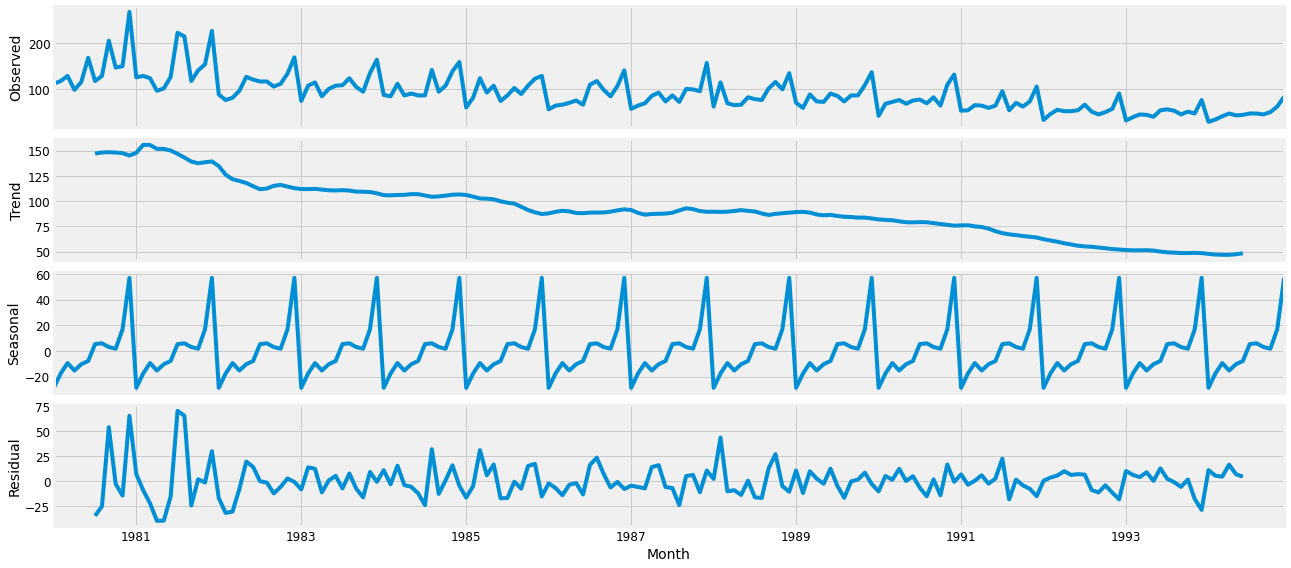

Minimo:  ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:1287.0116814376593


In [13]:
rose = Reemplazo_Asteriscos(rose, 'Rose ') # Se reemplazan asteriscos
y_rose = Reordenamiento_Meses(rose, 'Rose ')
SARIMA_Param(y_rose)

In [14]:
Predicciones_12Meses(y_rose, (1,1,1), (0,1,1,12),Diag = False, Plot_Pred = False)

La media pronosticada de las ventas para los siguientes 12 meses son los siguientes valores:
1995-01-01    21.735961
1995-02-01    29.196543
1995-03-01    36.222906
1995-04-01    37.567311
1995-05-01    34.349347
1995-06-01    39.669800
1995-07-01    46.063090
1995-08-01    39.043142
1995-09-01    38.227554
1995-10-01    41.083267
1995-11-01    49.860407
1995-12-01    76.462771
Freq: MS, dtype: float64
El MSE de las predicciones es 58.31
El RMSE de las predicciones es 7.64


## Sparkling

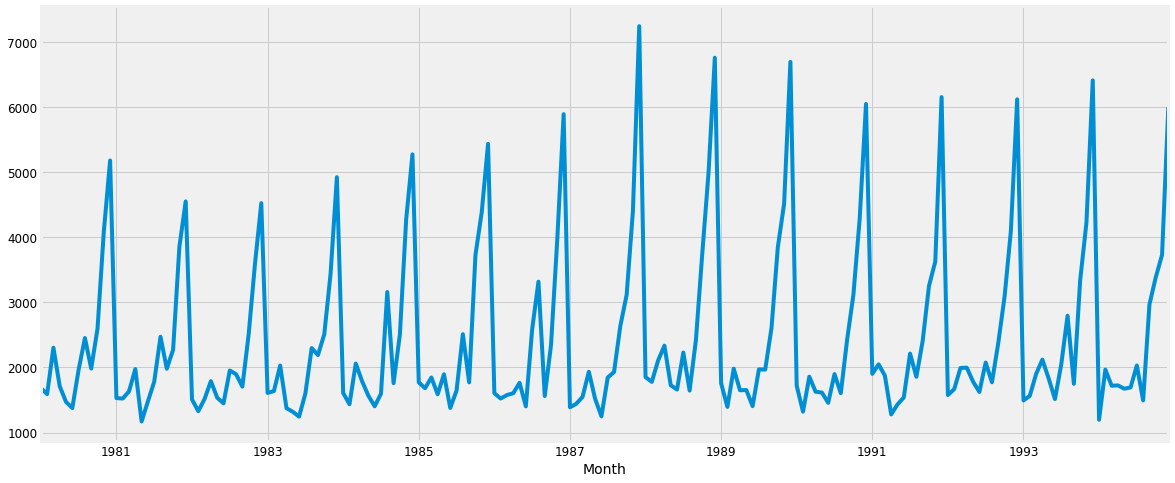

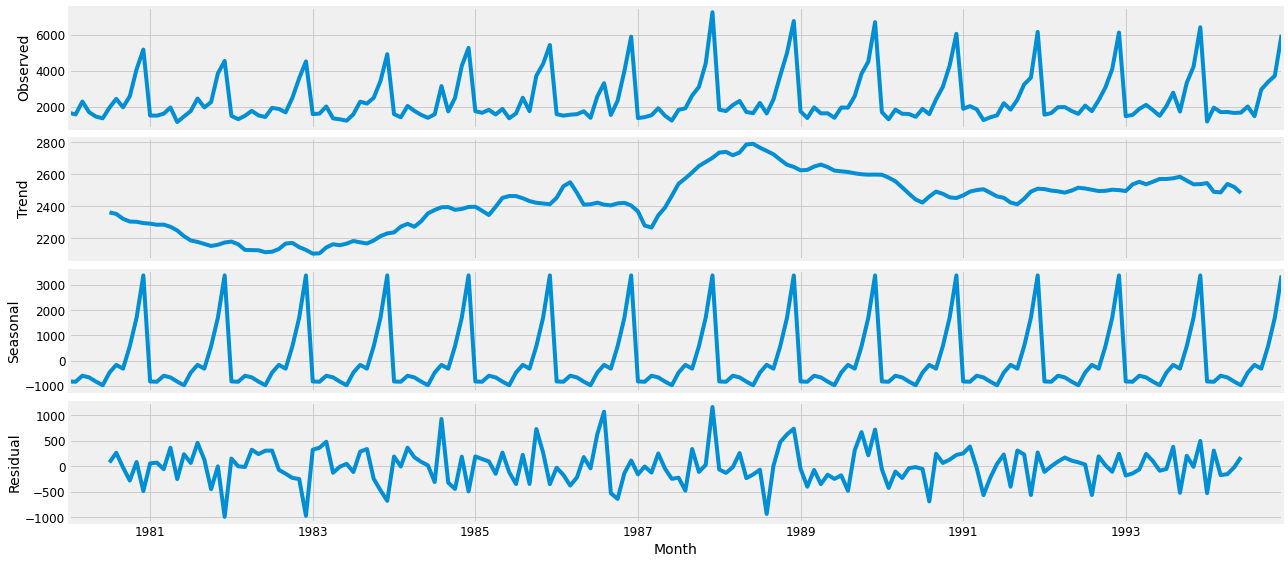

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Minimo:  ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:2271.5217326848706


In [15]:
y_sparkling = Reordenamiento_Meses(sparkling, 'sparkling ')
SARIMA_Param(y_sparkling)

In [16]:
Predicciones_12Meses(y_sparkling,(0, 1, 1),(0, 1, 1, 12),Diag = False, Plot_Pred = False)

La media pronosticada de las ventas para los siguientes 12 meses son los siguientes valores:
1995-01-01    1415.592331
1995-02-01    1746.038746
1995-03-01    1808.169608
1995-04-01    1800.624848
1995-05-01    1677.485084
1995-06-01    1572.620076
1995-07-01    2024.222047
1995-08-01    1898.463232
1995-09-01    2449.545190
1995-10-01    3288.779902
1995-11-01    3948.614024
1995-12-01    6141.863565
Freq: MS, dtype: float64
El MSE de las predicciones es 159111.01
El RMSE de las predicciones es 398.89


## Sweet white

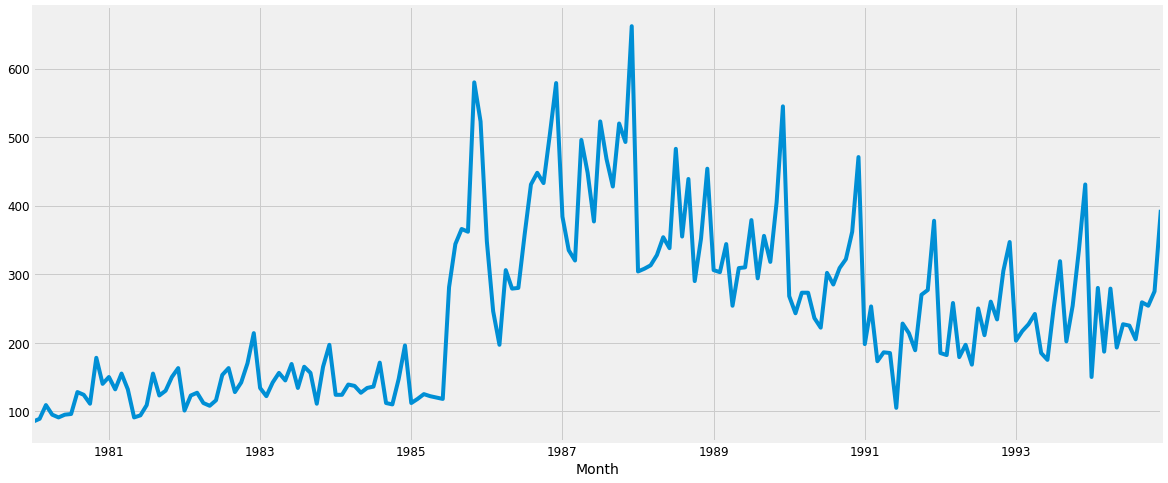

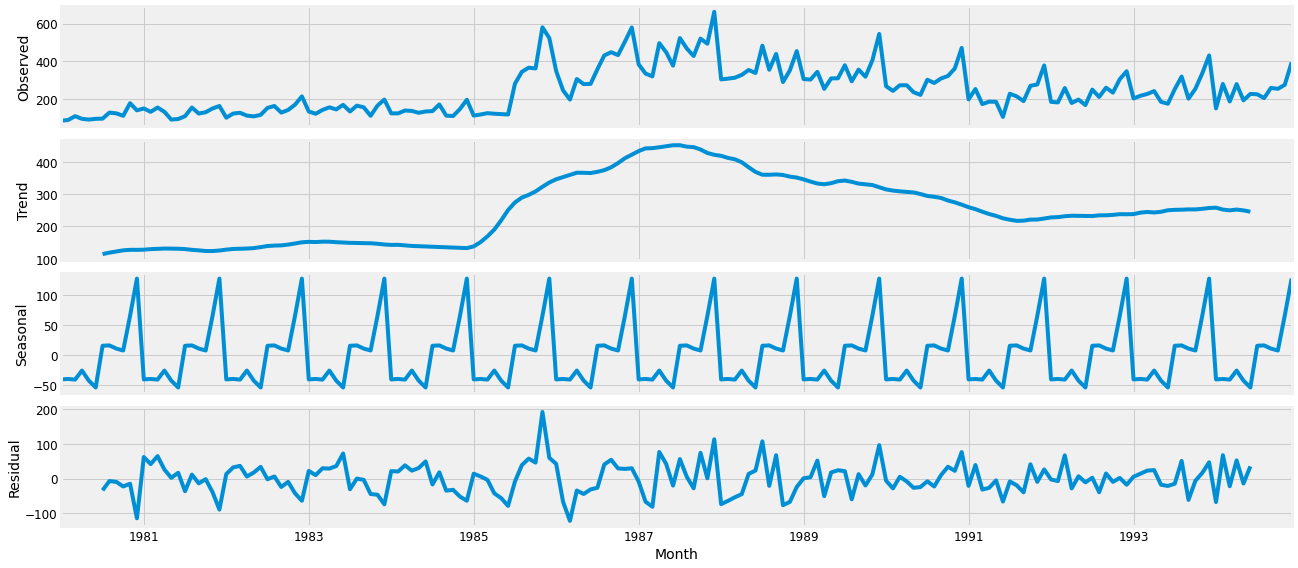

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Minimo:  ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:1671.9867567083738


In [17]:
y_sweet_white = Reordenamiento_Meses(sweet_white, 'Sweet white')
SARIMA_Param(y_sweet_white)

In [18]:
Predicciones_12Meses(y_sweet_white,(1, 1, 1),(1, 1, 1, 12),Diag = False, Plot_Pred = False)

La media pronosticada de las ventas para los siguientes 12 meses son los siguientes valores:
1995-01-01    168.938280
1995-02-01    208.997439
1995-03-01    182.837172
1995-04-01    218.873041
1995-05-01    184.907054
1995-06-01    185.714237
1995-07-01    238.427677
1995-08-01    231.437294
1995-09-01    244.625934
1995-10-01    242.034631
1995-11-01    288.929113
1995-12-01    374.558187
Freq: MS, dtype: float64
El MSE de las predicciones es 2450.14
El RMSE de las predicciones es 49.5


## Dry white

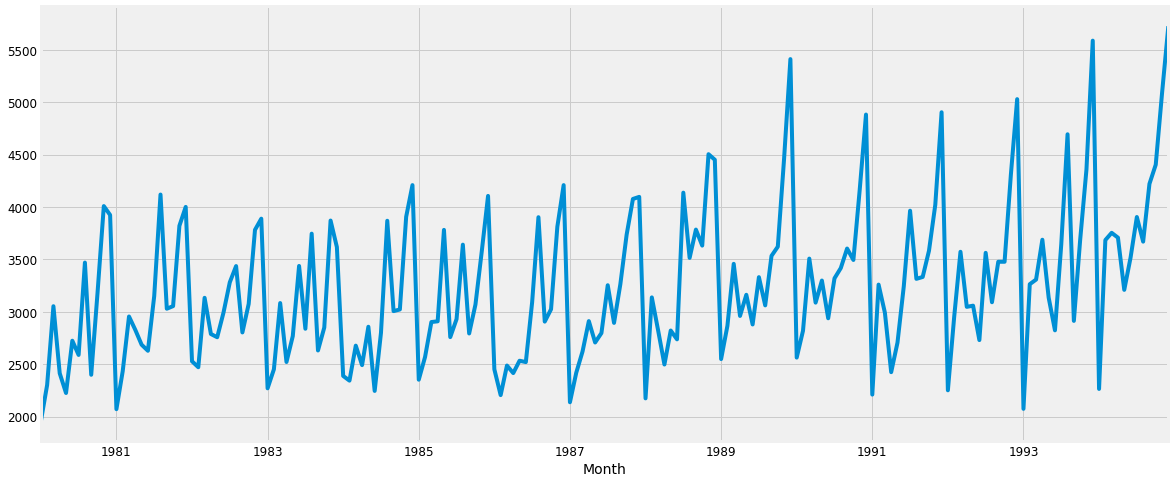

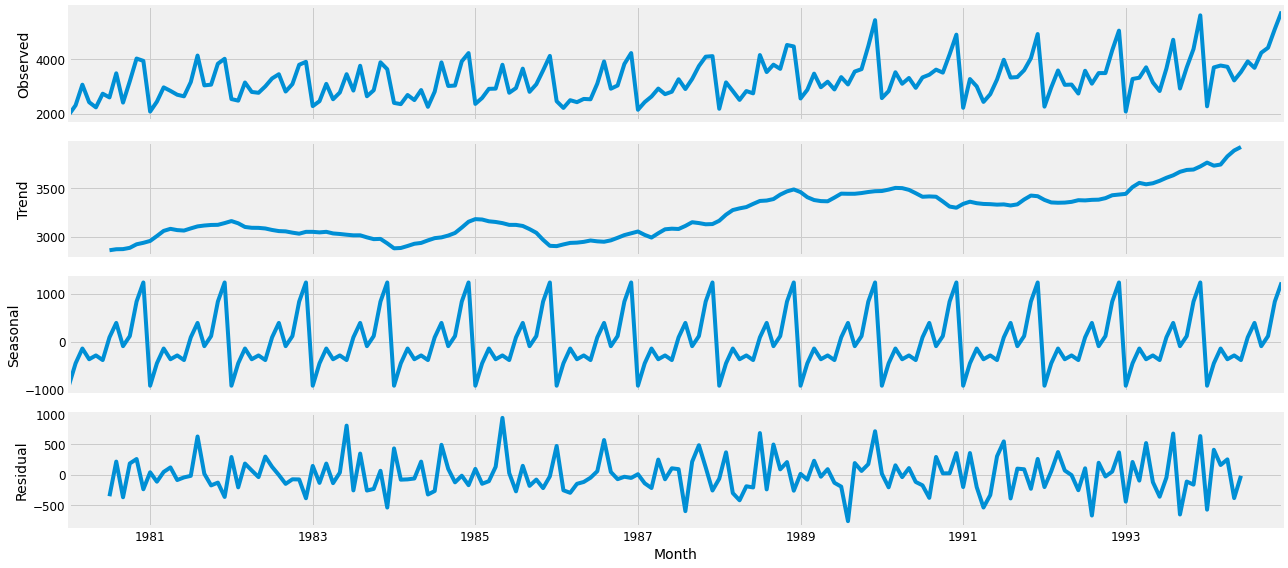

Minimo:  ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:2233.242568479068


In [19]:
y_dry_white = Reordenamiento_Meses(dry_white, 'Dry white')
SARIMA_Param(y_dry_white)

In [20]:
Predicciones_12Meses(y_dry_white,(0, 1, 1),(0, 1, 1, 12),Diag = False, Plot_Pred = False)

La media pronosticada de las ventas para los siguientes 12 meses son los siguientes valores:
1995-01-01    2772.408454
1995-02-01    3775.500079
1995-03-01    3956.855210
1995-04-01    3830.026039
1995-05-01    3615.157252
1995-06-01    3605.689673
1995-07-01    4218.307963
1995-08-01    4239.568927
1995-09-01    4097.769149
1995-10-01    4362.448996
1995-11-01    5048.002660
1995-12-01    5824.616165
Freq: MS, dtype: float64
El MSE de las predicciones es 207799.62
El RMSE de las predicciones es 455.85


# 2.2 - 2.8: Desempeño de pronosticos dado conjuntos de entrenamiento y validación

## Funciones:

Esta función recibe un dataframe objetivo, un par de SARIMA orden y season, y la cantidad de años del final de la serie de tiempo que se desea asignar al conjunto de validacion, y entrega un conjunto de entrenamiento, un conjunto de validación, y un modelo SARIMA entrenado con el conjunto de entrenamiento.

In [21]:
def Cjts_Training_Val_Modelo(Y_Obj, Orden_Obj, Seas_Orden_Obj,Year_Obj, Plot=False):
  Training_Set = Y_Obj[:-12*Year_Obj]
  Val_Set = Y_Obj[-12*Year_Obj:]
  Modelo_Obj = sm.tsa.statespace.SARIMAX(Training_Set,
                                order=Orden_Obj,
                                seasonal_order=Seas_Orden_Obj,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
  Modelo_Entrenado = Modelo_Obj.fit()
  return Training_Set, Val_Set, Modelo_Entrenado

Esta función recibe un conjunto objetivo y un modelo, retornando la predicción del conjunto y el intervalo de confianza al 80%, y ploteando la comparación de los datos y su predicción. Es posible predecir **meses adicionales** añadiendo un valor "Meses_Pred" mayor a 0.

In [22]:
def Realizar_Predicc_Cjto_Obj(Cjto_Obj, Modelo_Obj,Meses_Pred = 0, Plot = False):
  End_Year = len(Cjto_Obj)
  Predicc_Cjto = Modelo_Obj.get_prediction(start = Cjto_Obj.index[0],end = Cjto_Obj.index[-1]+ relativedelta(months=+Meses_Pred),dynamic=False)
  Predicc_Cjto_ci = Predicc_Cjto.conf_int(alpha=0.2)
  if Plot:
    ax = Cjto_Obj[:].plot(label='Observed')
    Predicc_Cjto.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(18, 8))
    ax.fill_between(Predicc_Cjto_ci.index,
                    Predicc_Cjto_ci.iloc[:, 0],
                    Predicc_Cjto_ci.iloc[:, 1], color='k', alpha=.2)
    ax.set_xlabel('Date')
    ax.set_ylabel('Sales')
    plt.legend()
    plt.show()
  return Predicc_Cjto, Predicc_Cjto_ci

Esta función entrega la performance de los datos originales y los datos predecidos.

In [23]:
def summary_performance(expected,predictions):
  forecast_errors = [expected[i]-predictions[i] for i in range(len(expected))]
  bias = sum(forecast_errors)*1.0/len(expected)
  mae = mean_absolute_error(expected, predictions)
  mse = mean_squared_error(expected, predictions)
  rmse = sqrt(mse)
  print(tabulate([['Bias:',bias], ['MAE:',mae], ['MSE:',mse], ['RMSE:',rmse]], headers=['Measure', 'Num'], tablefmt='orgtbl'))

Dado un conjunto y sus predicciones, grafica los residuos.

In [24]:
def Ploteo_Residuos(expected, prediction, wine_name, conjunto_name, Meses_Obj = 12):
  Residuos = expected - prediction.predicted_mean[:-Meses_Obj]
  plt.figure(figsize=(18, 8))
  plt.plot(Residuos)
  plt.ylabel('Residuals')
  plt.xlabel('Month')
  plt.title('Error in Naive Forecast \n on the  '+conjunto_name+' set for '+wine_name+' Wines')
  plt.show()
  return Residuos

Dado residuos, calcula su histograma.

In [25]:
def histograma(Elem_Obj, wine_name, conjunto_name):
  H, B = np.histogram(Elem_Obj, bins = 10)
  width = 0.7 * (B[1] - B[0])
  center = (B[:-1] + B[1:]) / 2
  plt.figure(figsize=(18, 8))
  plt.bar(center, H, align='center', width=width)
  plt.title('Histogram of Residuals of Forecast on the  '+conjunto_name+' set for '+wine_name+' Wines')
  plt.ylabel('Frequency')
  plt.xlabel('Residuos')
  plt.show()

## Aplicacion

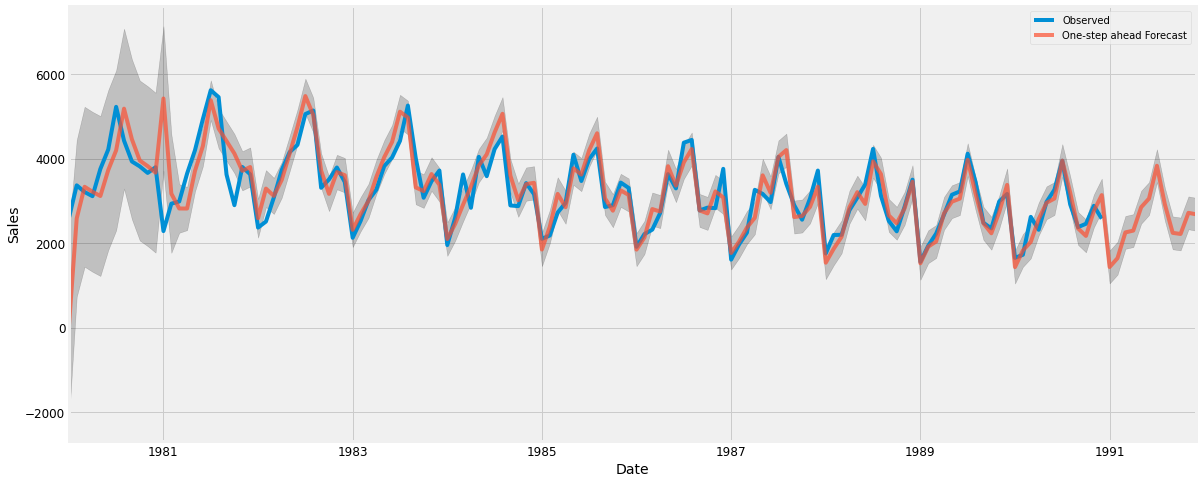

| Measure   |        Num |
|-----------+------------|
| Bias:     |    -12.645 |
| MAE:      |    326.396 |
| MSE:      | 262909     |
| RMSE:     |    512.746 |


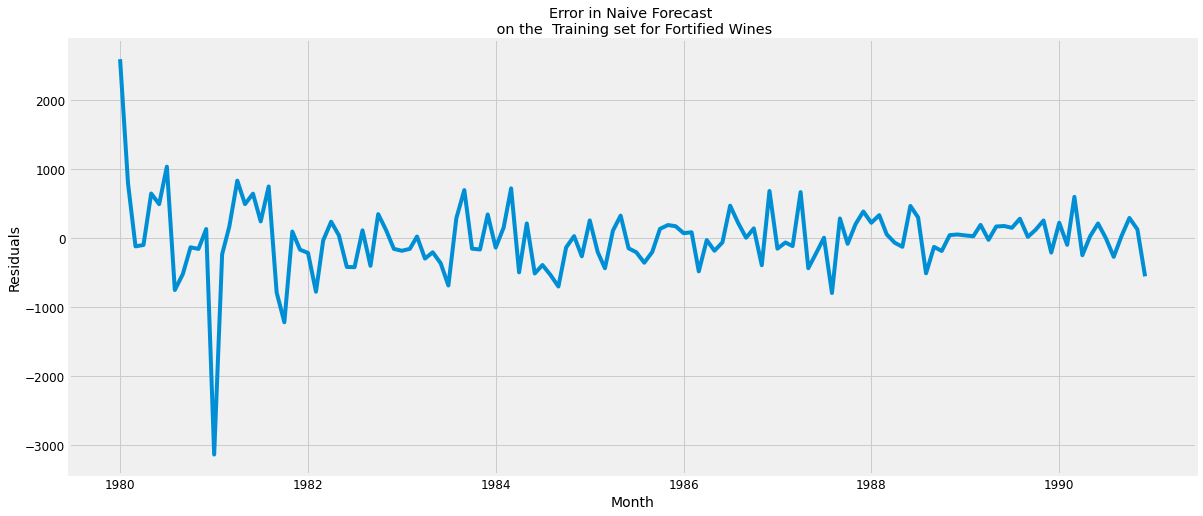

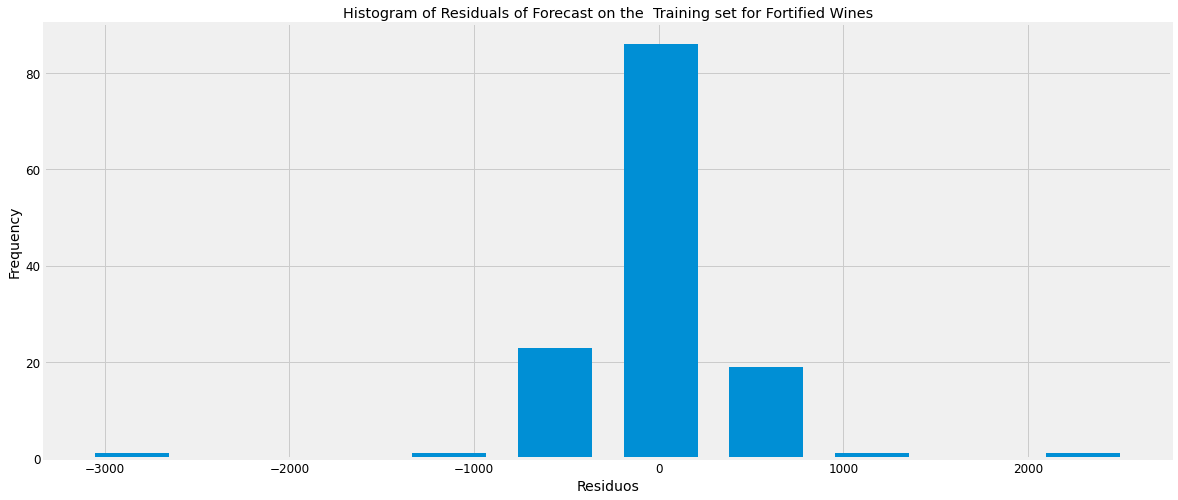

In [26]:
# Se crean los conjuntos de entrenamiento y validación
Training_Fortified, Val_Fortified, Modelo_Fortified = Cjts_Training_Val_Modelo(y_fortified, (0,1,1), (1,1,1,12), 4)
# Se realiza una predicción del conjunto de Entrenamiento
Train_Pred_Fortified, Train_Pred_Fortified_ci = Realizar_Predicc_Cjto_Obj(Training_Fortified,Modelo_Fortified, Plot=True,Meses_Pred = 12)
# Se evalua el desempeño del conjunto de entrenamiento
summary_performance(Training_Fortified,Train_Pred_Fortified.predicted_mean[:-12])
# Se ven los residuos
Residuos_Fortified = Ploteo_Residuos(Training_Fortified,Train_Pred_Fortified,'Fortified', 'Training')
# Se grafica un histograma de los residuos
histograma(Residuos_Fortified,'Fortified', 'Training')

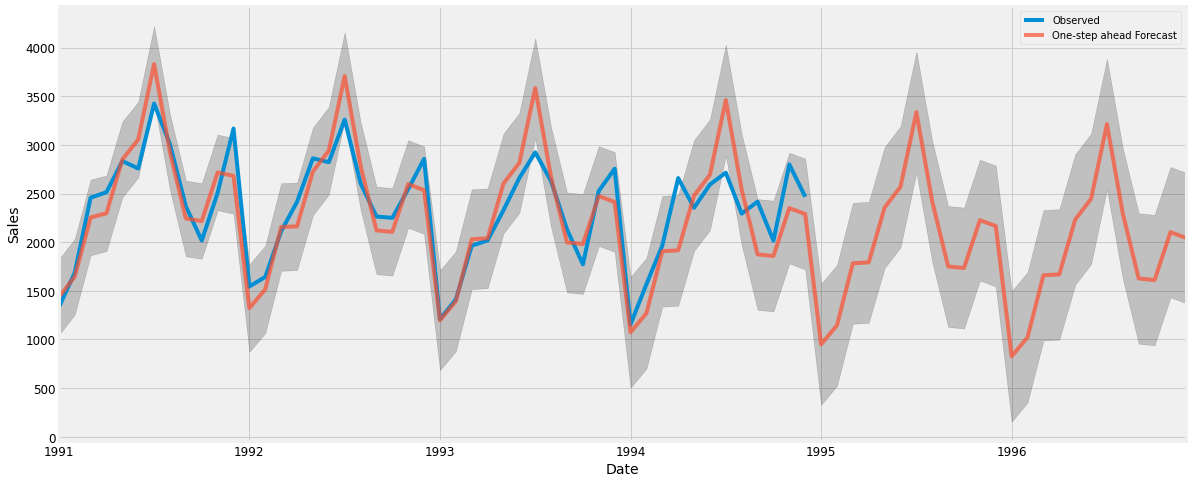

| Measure   |        Num |
|-----------+------------|
| Bias:     |    17.4948 |
| MAE:      |   214.412  |
| MSE:      | 79446.1    |
| RMSE:     |   281.862  |


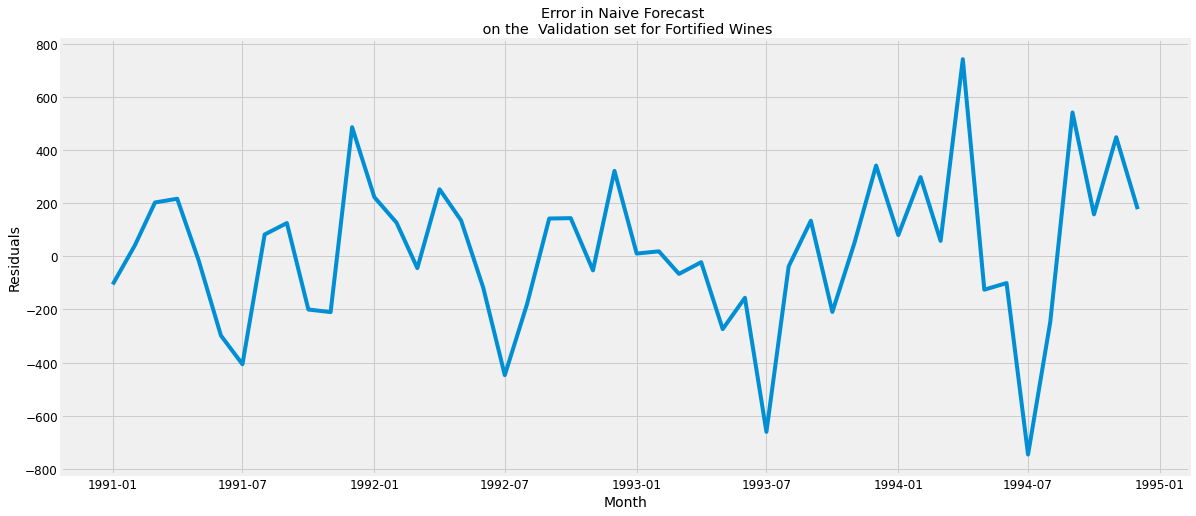

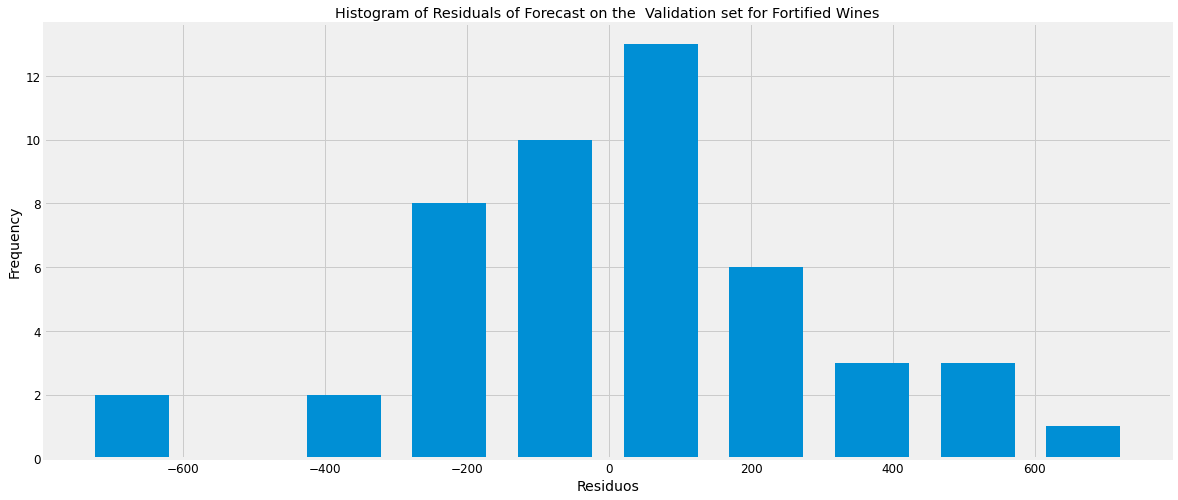

In [27]:
# Se realiza una predicción del conjunto de Validación
Meses_A_Pred = 24
Val_Pred_Fortified, Val_Pred_Fortified_ci = Realizar_Predicc_Cjto_Obj(Val_Fortified,Modelo_Fortified, Plot=True,Meses_Pred = Meses_A_Pred)
# Se evalua el desempeño del conjunto de validación
summary_performance(Val_Fortified,Val_Pred_Fortified.predicted_mean[:-1*Meses_A_Pred])
# Se ven los residuos
Residuos_Fortified = Ploteo_Residuos(Val_Fortified,Val_Pred_Fortified,'Fortified', 'Validation', Meses_A_Pred)
# Se grafica un histograma de los residuos
histograma(Residuos_Fortified,'Fortified', 'Validation')

Falta el tema del 2.8

# 2.9 - 2.12: Diferenciación

2.9: Se crea la función Diferenciacion(), la cual aplica logaritmo al dataframe objetivo, y se realiza la operación de diferenciacion con el mes anterior mediante pandas.diff(). A este resultado se le aplica nuevamente otra diferenciación con período = 12 con el fin de eliminar la estacionalidad.

In [28]:
def Diferenciacion(DF_Obj, Plot = True):
  Diff_1 = np.log(DF_Obj).diff() # Naive
  Diff_2 = Diff_1.diff(periods=12) # Seasonal Naive
  if Plot:
    plt.plot(Diff_1)
    plt.show()
    plt.plot(Diff_2)
    plt.show()
  return Diff_1, Diff_2

Se aplica Diferenciacion() al dataframe de vinos Fortified, y se descartan los valores nulos del resultado:

In [ ]:
Diff_1_Fortified, Diff_2_Fortified = Diferenciacion(y_fortified)
Diff_2_Fortified_NoNaN = Diff_2_Fortified.dropna()

Se convierte un arreglo de valores en una matriz

In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

Se fija la "Seed" de los numeros aleatorios con el fin de poder reproducir el mismo resultado

In [ ]:
numpy.random.seed(7)

Se preprocesa el dataframe obtenido de la diferenciación:

In [297]:
dataframe = Diff_2_Fortified_NoNaN
dataset = dataframe.values.reshape(-1, 1)
dataset = dataset.astype('float32')
# Se estandariza el dataset con un MinMaxScaler()
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

Se divide el dataframe en conjuntos de entrenamiento y prueba para ser procesados por la LSTM

In [302]:
# Se divide en conjuntos de entrenamiento y prueba, con 33% de los datos correspondientes a este último
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# Se reformulan los datos con una diferencia de 12 meses, para que de esta forma
#   12 valores en el conjunto permitan entregar el valor siguiente en la red:
look_back = 12
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# Se les aplica reshape a los conjuntos para que tengan la forma: [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))

Se crea la red LSTM y se entrena con el conjunto de entrenamiento:

In [299]:
model = Sequential()
model.add(LSTM(32, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)

Se procede a utilizar el conjunto de entrenamiento y prueba para probar la red:

In [303]:
# Se realizan predicciones del conjunto de entrenamiento
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Se des-estandariza los resultados
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# Se calcula RMSE
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.11 RMSE
Test Score: 0.12 RMSE


Se plottea el conjunto de entrenamiento

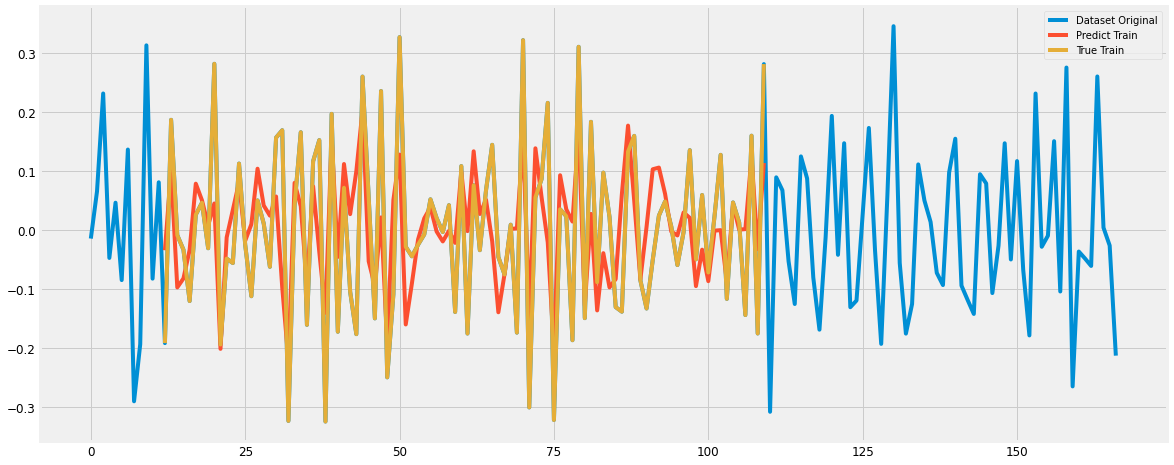

In [320]:
# Se procesan los resultados del cjto de entrenamiento para ser plotteados:
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

trainPredictPlot_OG = numpy.empty_like(dataset)
trainPredictPlot_OG[:, :] = numpy.nan
trainPredictPlot_OG[-len(trainY.T) + len(trainPredict)+look_back:len(trainPredict)+look_back, :] = trainY.T

# Gráficos:
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(trainPredictPlot_OG)
plt.legend(('Dataset Original','Predict Train','True Train'))
plt.show()

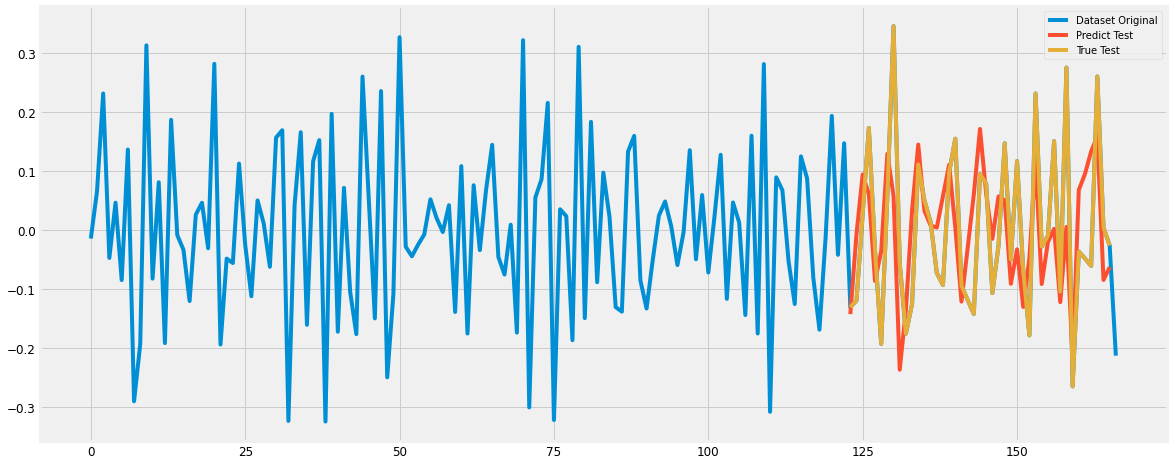

In [326]:
# Se procesan los resultados del cjto de prueba para ser plotteados:
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

testPredictPlot_OG = numpy.empty_like(dataset)
testPredictPlot_OG[:, :] = numpy.nan
testPredictPlot_OG[-len(testY.T) + len(dataset)-1:len(dataset)-1, :] = testY.T

# Gráficos:
plt.plot(scaler.inverse_transform(dataset))
plt.plot(testPredictPlot)
plt.plot(testPredictPlot_OG)
#plt.plot(testPredictPlot)
plt.legend(('Dataset Original','Predict Test','True Test'))
plt.show()

Se procederá a realizar una predicción del conjunto total de datos proveniente de la diferenciación, con el fin de obtener predicciones a futuro de 2 meses.

Test Score: 0.11 RMSE


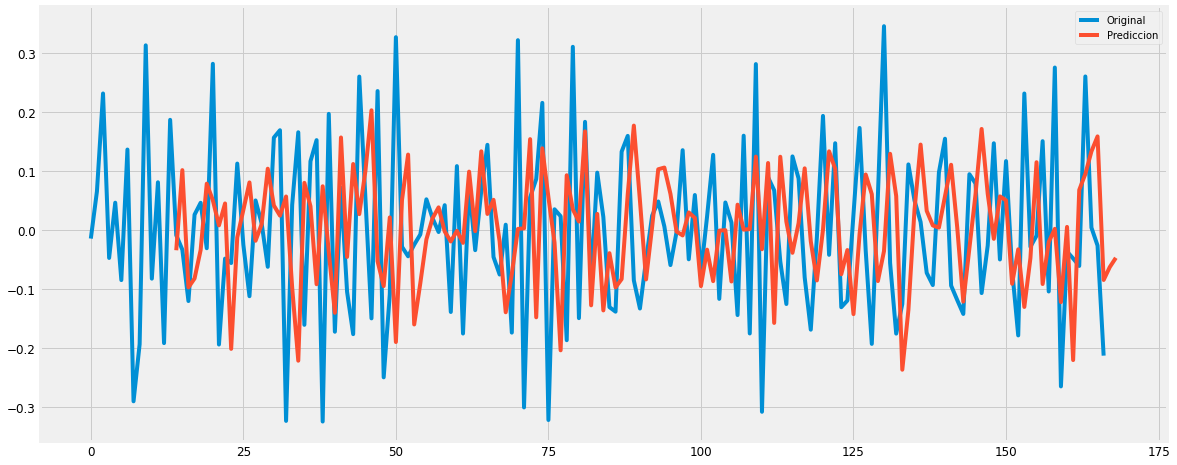

In [327]:
# Se utiliza el dataset completo para originar el conjunto de Test:
testX, testY = create_dataset(dataset, look_back)
# Reshape:
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))

# Se predice el nuevo conjunto de test:
testPredict = model.predict(testX)

# Se añade el resultado obtenido (el nuevo mes predecido) al dataframe original,
# y se guarda en un nuevo dataframe:
new_test = np.concatenate((dataset,testPredict[-1:]))

# Se preprocesa el nuevo conjunto de test:
testX, testY = create_dataset(new_test, look_back)
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))

# Se predice el nuevo conjunto de test:
testPredict = model.predict(testX)

# Se des-estandarizan:
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# Se calcula el RMSE:
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# # Se procesan los resultados del cjto de prueba para ser plotteados:
testPredictPlot = numpy.zeros((dataset.shape[0]+2,1))
testPredictPlot[:, :] = numpy.nan
testPredictPlot[-len(testPredict):, :] = testPredict

# Se Grafica:
plt.plot(scaler.inverse_transform(dataset))
plt.plot(testPredictPlot)
plt.legend(('Original','Prediccion'))
plt.show()

Se concatenan los resultados obtenidos al dataframe de la differenciacion

In [ ]:
new_diff = np.concatenate((Diff_2_Fortified, testPredict[-2:,0]))
plt.plot(new_diff)
plt.plot(Diff_2_Fortified.values)
plt.show()

Se realizan las diferenciaciones a la inversa:

In [331]:
# Primera diff inversa
periods = 12
df = Diff_1_Fortified.copy()
df.loc[last[-2]] = 0.0
df.loc[last[-1]] = 0.0
diffs = asd.copy()
diffs[:] = new_diff

df = df[1:]
diffs = diffs[1:]

restored = df.copy()
restored.iloc[periods:] = np.nan
for d, val in diffs.iloc[periods:].iteritems():
  restored.loc[d] = restored.loc[d - pd.DateOffset(months=periods)] + val

res = pd.concat([df, diffs, restored], axis=1)
res.columns = ['original', 'diffs', 'restored']

Restaurado = Diff_1_Fortified.copy()
Restaurado.loc[last[-2]] = 0.0
Restaurado.loc[last[-1]] = 0.0
Restaurado.loc[1:] = res['restored']


### Segunda Diff Inversa:
periods=1
df = np.log(y_fortified.copy())
df.loc[last[-2]] = 0.0
df.loc[last[-1]] = 0.0
diffs = Restaurado.copy()


restored = df.copy()
restored.iloc[periods:] = np.nan
for d, val in diffs.iloc[periods:].iteritems():
  restored.loc[d] = restored.loc[d - pd.DateOffset(months=periods)] + val

res = pd.concat([df, diffs, restored], axis=1)
res.columns = ['original', 'diffs', 'restored']

Se muestra el resultado de las predicciones, en conjunto con los valores de los últimos 14 meses.

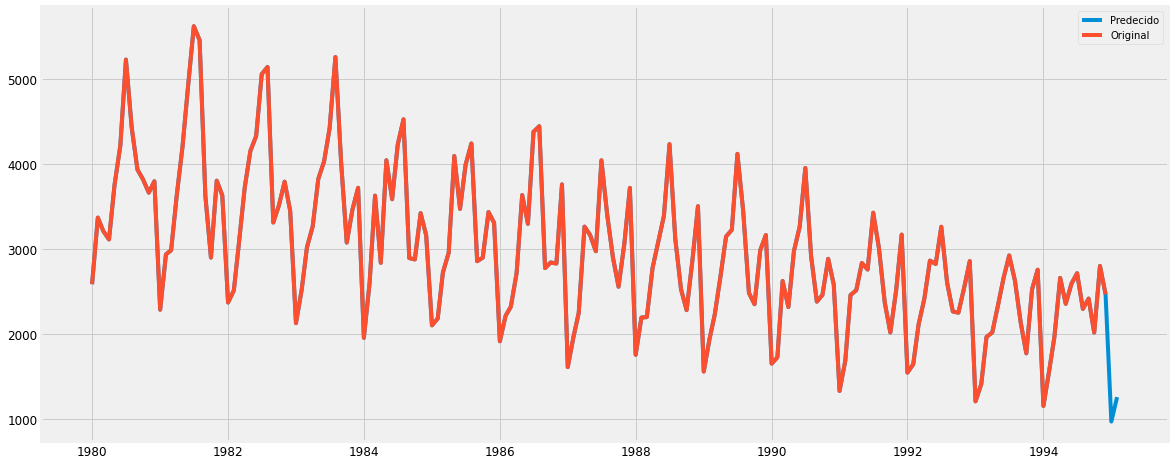

Month
1994-01-01    1154.000000
1994-02-01    1568.000000
1994-03-01    1965.000000
1994-04-01    2659.000000
1994-05-01    2354.000000
1994-06-01    2592.000000
1994-07-01    2714.000000
1994-08-01    2294.000000
1994-09-01    2416.000000
1994-10-01    2016.000000
1994-11-01    2799.000000
1994-12-01    2467.000000
1995-01-01     970.276864
1995-02-01    1257.543481
Freq: MS, Name: restored, dtype: float64


In [332]:
plt.plot(np.exp(res['restored']))
plt.plot(y_fortified)
plt.legend(('Predecido','Original'))
plt.show()
print(np.exp(res['restored'])[-14:])

# Obsoleto

In [ ]:
### NO OCUPAR!

def Cjts_Training_Val(Y_Obj, Orden_Obj, Seas_Orden_Obj,Year_Obj, Plot=False):
  Training_Set = Y_Obj[:-12*Year_Obj]
  Val_Set = Y_Obj[-12*Year_Obj:]
  mod = sm.tsa.statespace.SARIMAX(Y_Obj,
                                order=Orden_Obj,
                                seasonal_order=Seas_Orden_Obj,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
  results = mod.fit()
  Traininig_Pred = results.get_prediction(end = -12*Year_Obj, dynamic=False)
  Val_Pred = results.get_prediction(start = -12*Year_Obj,end = len(Y_Obj) + 11, dynamic=False)
  Val_Pred_ci = Val_Pred.conf_int(alpha=0.2)
  if Plot:
    ax = Y_Obj['1984':].plot(label='Observed')
    Val_Pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(18, 8))
    ax.fill_between(Val_Pred_ci.index,
                    Val_Pred_ci.iloc[:, 0],
                    Val_Pred_ci.iloc[:, 1], color='k', alpha=.2)
    ax.set_xlabel('Date')
    ax.set_ylabel('Fortified Sales')
    plt.legend()
    plt.show()
    y_forecasted = Val_Pred.predicted_mean
    y_truth = Y_Obj['1994-11-01':]
    mse = ((y_forecasted - y_truth) ** 2).mean()
    print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
    print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))
  return Traininig_Pred,Training_Set, Val_Pred, Val_Set, Val_Pred_ci

In [ ]:
from keras.preprocessing.sequence import TimeseriesGenerator
Array = TimeseriesGenerator(Diff_2_Fortified.dropna().values.reshape((-1,1)), Diff_2_Fortified.dropna().values.reshape((-1,1)), length=12, batch_size=30) 
print(Array)

(1, 1)
Train Score: 0.11 RMSE
Test Score: 0.12 RMSE
123 167


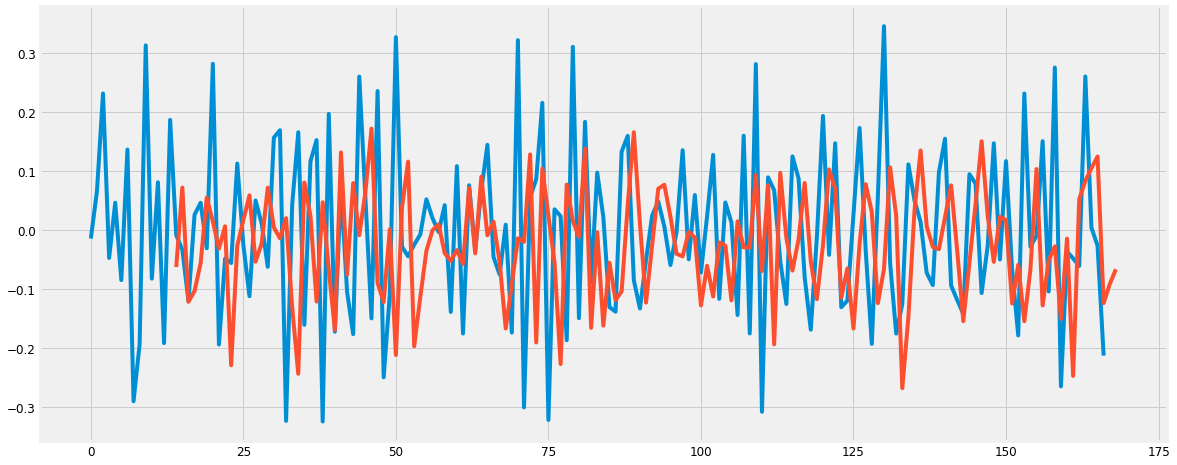

In [ ]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 12
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(dataset, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(32, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
print(testPredict[-1:].shape)
new_test = np.concatenate((dataset,testPredict[-1:]))
testX, testY = create_dataset(new_test, look_back)
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.zeros((dataset.shape[0]+2,1))
#testPredictPlot = np.concatenate((testPredictPlot,numpy.empty_like(dataset)))
testPredictPlot[:, :] = numpy.nan
print(len(trainPredict)+(look_back*2)+1,len(dataset))
testPredictPlot[-len(testPredict):, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(testPredictPlot)
#plt.plot(testPredict)
plt.show()

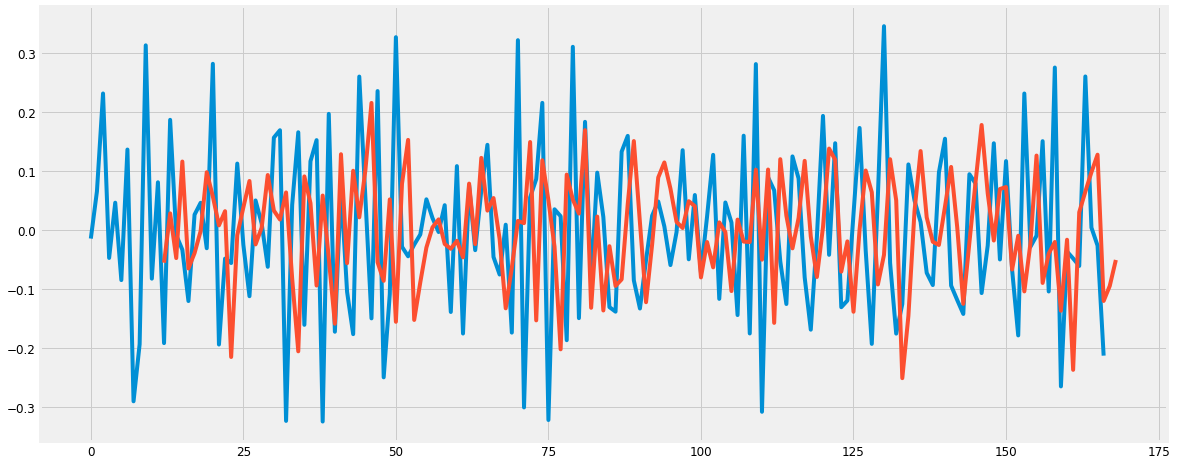

In [ ]:
testPredictPlot = numpy.zeros((dataset.shape[0]+2,1))
#testPredictPlot = np.concatenate((testPredictPlot,numpy.empty_like(dataset)))
testPredictPlot[:, :] = numpy.nan
testPredictPlot[-len(testPredict):, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(testPredictPlot)
#plt.plot(testPredict)
plt.show()

In [ ]:
testPredict = model.predict(testX)
print(testPredict[-1:].shape)
new_test = np.concatenate((dataset,testPredict[-1:]))
testX, testY = create_dataset(new_test, look_back)
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.zeros((dataset.shape[0]+2,1))
#testPredictPlot = np.concatenate((testPredictPlot,numpy.empty_like(dataset)))
testPredictPlot[:, :] = numpy.nan
print(len(trainPredict)+(look_back*2)+1,len(dataset))
testPredictPlot[12:, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(testPredictPlot)
#plt.plot(testPredict)
plt.show()

(1, 1)


ValueError: ignored

124 167


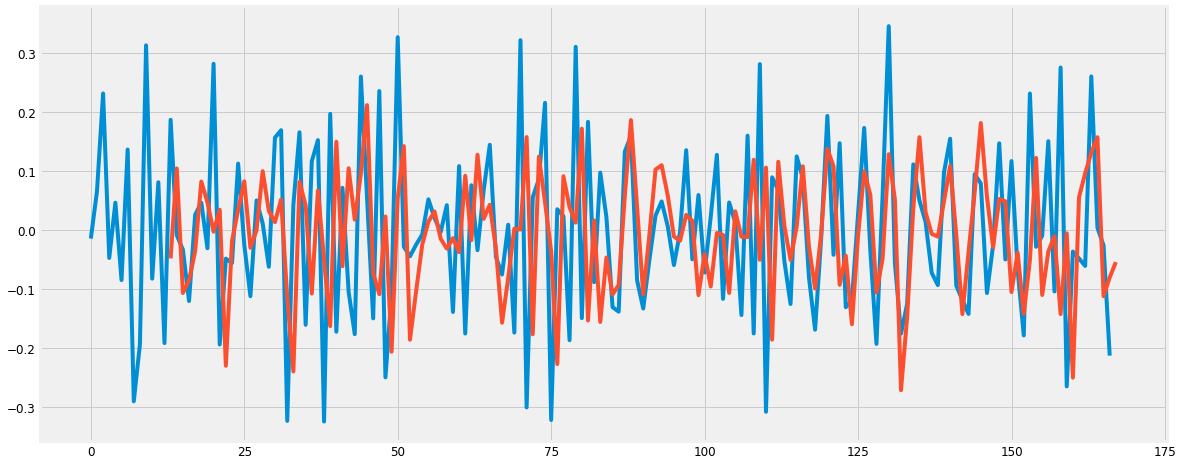

In [ ]:
testPredictPlot = numpy.zeros((dataset.shape[0]+1,1))
#testPredictPlot = np.concatenate((testPredictPlot,numpy.empty_like(dataset)))
testPredictPlot[:, :] = numpy.nan
print(len(trainPredict)+(look_back*2)+1,len(dataset))
testPredictPlot[12+1:, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(testPredictPlot)
#plt.plot(testPredict)
plt.show()

In [ ]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[4:, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
#plt.plot(dataset)
plt.plot(testPredict)
plt.show()

In [ ]:
for i in range()
print([testPredict])
print(dataset)

SyntaxError: ignored

In [ ]:
print(Diff_2_Fortified)
print(Diff_2_Fortified.resample("1d").mean().reindex())

Month
1980-01-01         NaN
1980-02-01         NaN
1980-03-01         NaN
1980-04-01         NaN
1980-05-01         NaN
                ...   
1994-08-01   -0.060978
1994-09-01    0.260218
1994-10-01    0.003954
1994-11-01   -0.026381
1994-12-01   -0.213040
Freq: MS, Name: Fortified, Length: 180, dtype: float64
Month
1980-01-01        NaN
1980-01-02        NaN
1980-01-03        NaN
1980-01-04        NaN
1980-01-05        NaN
               ...   
1994-11-27        NaN
1994-11-28        NaN
1994-11-29        NaN
1994-11-30        NaN
1994-12-01   -0.21304
Freq: D, Name: Fortified, Length: 5449, dtype: float64


In [ ]:
from keras.preprocessing.sequence import TimeseriesGenerator
close_data = Diff_2_Fortified_NoNaN.values
close_data = close_data.reshape((-1,1))

split_percent = 0.80
split = int(split_percent*len(close_data))

close_train = close_data[:split]
close_test = close_data[split:]

date_train = Diff_2_Fortified_NoNaN.index[:split]
date_test = Diff_2_Fortified_NoNaN.index[split:]

print(len(close_train))
print(len(close_test))
look_back = 12

train_generator = TimeseriesGenerator(close_train, close_train, length=look_back, batch_size=20)     
test_generator = TimeseriesGenerator(close_test, close_test, length=look_back, batch_size=1)
from keras.models import Sequential
from keras.layers import LSTM, Dense

model = Sequential()
model.add(
    LSTM(10,
        activation='relu',
        input_shape=(look_back,1))
)
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

num_epochs = 25
model.fit_generator(train_generator, epochs=num_epochs, verbose=0)

prediction = model.predict_generator(test_generator)

close_train = close_train.reshape((-1))
close_test = close_test.reshape((-1))
prediction = prediction.reshape((-1))


close_data = close_data.reshape((-1))

def predict(num_prediction, model):
    prediction_list = close_data[-look_back:]
    
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list
    
def predict_dates(num_prediction):
    last_date = Diff_2_Fortified_NoNaN.index.values[-1]
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
    return prediction_dates

num_prediction = 2
forecast = predict(num_prediction, model)
forecast_dates = predict_dates(num_prediction)

In [ ]:
num_prediction = 2
forecast = predict(num_prediction, model)
forecast_dates = predict_dates(num_prediction)
plt.plot(forecast)

In [ ]:
print(Diff_2_Fortified.index.min())
last = pd.date_range(start=Diff_2_Fortified.index.min(),freq="MS", periods=182)
print(last)
asd = Diff_2_Fortified.copy()
asd.loc[last[-2]] = 0.0
asd.loc[last[-1]] = 0.0
print(asd)

1980-01-01 00:00:00
DatetimeIndex(['1980-01-01', '1980-02-01', '1980-03-01', '1980-04-01',
               '1980-05-01', '1980-06-01', '1980-07-01', '1980-08-01',
               '1980-09-01', '1980-10-01',
               ...
               '1994-05-01', '1994-06-01', '1994-07-01', '1994-08-01',
               '1994-09-01', '1994-10-01', '1994-11-01', '1994-12-01',
               '1995-01-01', '1995-02-01'],
              dtype='datetime64[ns]', length=182, freq='MS')
Month
1980-01-01         NaN
1980-02-01         NaN
1980-03-01         NaN
1980-04-01         NaN
1980-05-01         NaN
                ...   
1994-10-01    0.003954
1994-11-01   -0.026381
1994-12-01   -0.213040
1995-01-01    0.000000
1995-02-01    0.000000
Freq: MS, Name: Fortified, Length: 182, dtype: float64


In [ ]:
new_df = 

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
         ...   
177    0.003954
178   -0.026381
179   -0.213040
180   -0.094922
181   -0.050855
Length: 182, dtype: float64
